In [1]:
import bForStrain as bFS

westUS_mesh=bFS.Mesh()
westUS_mesh.construct()

Building mesh from coordinates and extent given in params.py

 Smooth triangulation...

 -----------------------------------------------------------------------
      |ITER.|          |MOVE(X)|          |DTRI(X)|          |T. ITER|  
 -----------------------------------------------------------------------
          4               1440               3842             0.019000
          8                581               3838             0.021000
         12                114               3836             0.023000
         16                 10               3836             0.023000
         20                 10               3836             0.023000
         24                  6               3836             0.023000
         28                  6               3836             0.024000
         32                  6               3836             0.023000


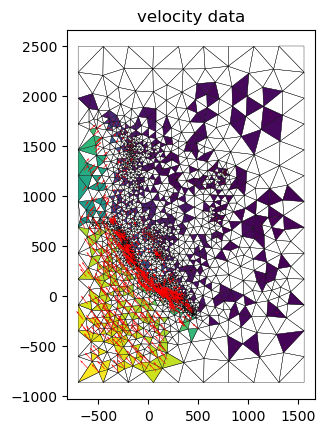

In [2]:
westUS_mesh.plot_vels()

In [3]:
results = bFS.Inversion(westUS_mesh)


Computing Body Force Green's Functions
Computing Creepings Green's functions calculation
  10 % completed
  20 % completed
  30 % completed
  40 % completed
  50 % completed
  60 % completed
  70 % completed
  80 % completed
  90 % completed
  100 % completed
Performing inversion
Inversion time: 5.7 seconds
Chi-2 for beta = 40: 6.04


In [5]:
results.save("results_beta40.pkl")
westUS_mesh.save("mesh.pkl")

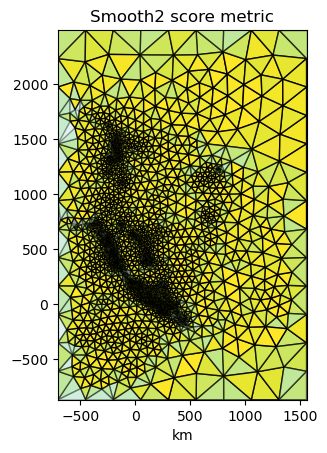

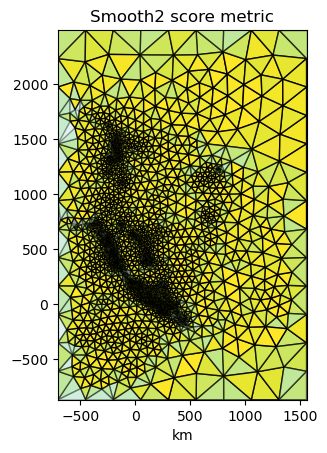

In [8]:
copy_mesh =(bFS.load("mesh.pkl"))
copy_mesh.plot_mesh()